/var/folders/lc/bd2hdpn53fnd_gtfy8gt049h0000gn/T/ipykernel_33772/18139550.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punk_facts_df["counts"] = pd.to_numeric(punk_facts_df["counts"])
/Users/ignacioguerra/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/ignacioguerra/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set o

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Punks that Share this Attribute</th>
      <th>Rarity %</th>
      <th>Rarity Score</th>
    </tr>
    <tr>
      <th>Attribute</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Female</th>
      <td>3840</td>
      <td>38.40</td>
      <td>2.604167</td>
    </tr>
    <tr>
      <th>6 accessories</th>
      <td>11</td>
      <td>0.11</td>
      <td>909.090909</td>
    </tr>
    <tr>
      <th>Earring</th>
      <td>2459</td>
      <td>24.59</td>
      <td>4.066694</td>
    </tr>
    <tr>
      <th>Hot Lipstick</th>
      <td>696</td>
      <td>6.96</td>
      <td>14.367816</td>
    </tr>
    <tr>
      <th>Classic Shades</th>
      <td>502</td>
      <td>5.02</td>
      <td>19.920319</td>
    </tr>
    <tr>
      <th>Mole</th>
      <td>644</td>
      <td>6.44</td>
      <td>15.527950</td>
    </tr>
    <tr>
      <th>Straight

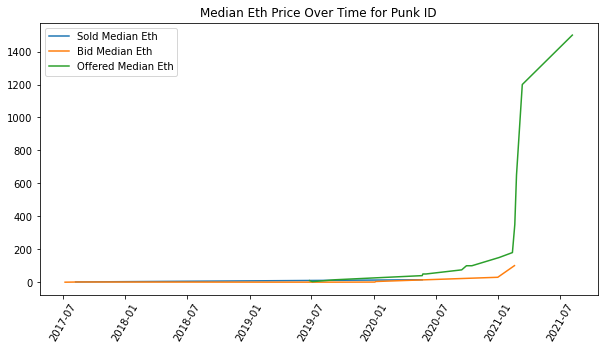

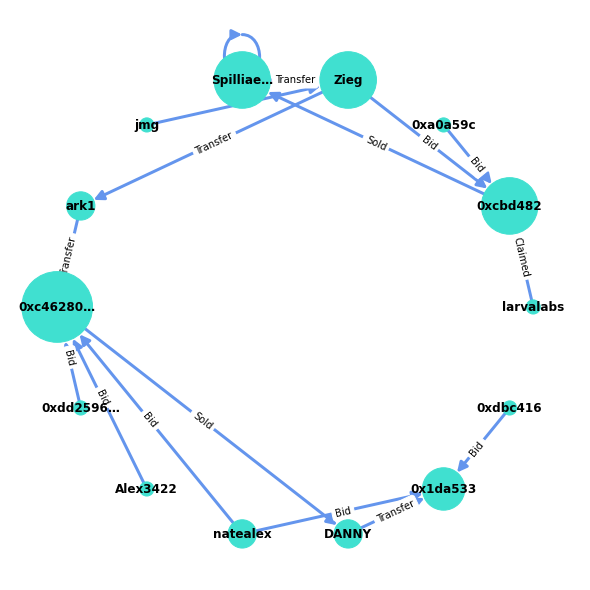

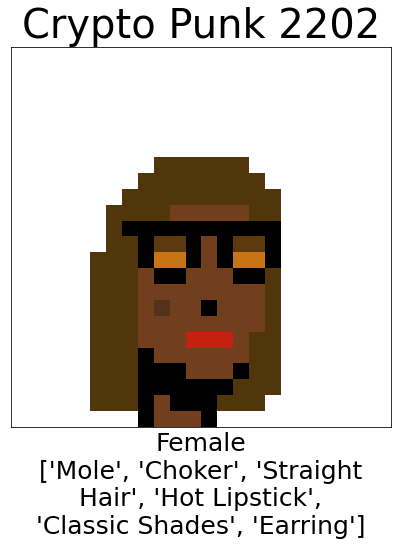

In [1]:
##################################################################
# IMPORT DEPENDENCIES
##################################################################

# Import Dependencies
from flask import Flask, render_template, jsonify, json, request, redirect, url_for
from flask_pymongo import PyMongo
import pymongo

from bson.json_util import dumps
import json
import pandas as pd
import random

# Import MongoDB and AWS access paramaters
from config import user, password, key_id, secret_access_key

# Import plotting libraries
import matplotlib.pyplot as plt
import networkx as nx 
import plotly.graph_objects as go
from textwrap import wrap

# Import AWS SDK
import boto3

##################################################################


##############################################
# BUILD THE CRYPTO PUNKS FACTS
##############################################

def punkFacts(id_selection):

    # construct the connection string for Atlas
    CONNECTION_STRING = "mongodb+srv://"+ user + ":" + password +"@cluster0.wddnt.mongodb.net/crypto_punks_mdb?retryWrites=true&w=majority"
    # Create the connection client to Atlas
    client = pymongo.MongoClient(CONNECTION_STRING) 
    # indicate the database to access in Atlas
    db = pymongo.database.Database(client,'crypto_punks_mdb')
    # assign the connection to the database and collection to variables (i.e. this still is not 'reading' 
    # the data from the database)
    attributes = pymongo.collection.Collection(db, 'attributes_col')
    crypto_punks = pymongo.collection.Collection(db, 'crypto_punks_col')

    # search the database for the unique punk_id value provided as input to 
    # the function and assign the output to a variable. The output will be an object.
    crypto_punks_data = json.loads(dumps(crypto_punks.find({"punk_id":id_selection}))) #[Replace "3600" for sample in the final code]
    
    # import the list of all crypto punk attributes
    attributes_data = json.loads(dumps(attributes.find()))
    
    # Convert the json lists to dataframes and drop un-needed columns
    punks_df = pd.DataFrame(crypto_punks_data)
    punks_df = punks_df.drop(columns=["_id"])
    attributes_df = pd.DataFrame(attributes_data)
    attributes_df = attributes_df.drop(columns=["_id"])

    # Create the summary punk_facts dataframe
    # 1. Create an empty list for all the attributes in the punk_id
    punk_attribute_list = []

    # 2. Populate the list
    punk_attribute_list.append(punks_df.at[0,"type"])
    punk_accessories = punks_df.at[0,"accessories"]
    for accessory in punk_accessories:
      punk_attribute_list.append(accessory)
    punk_attribute_list.append(str(len(punk_accessories))+" accessories")
    
    # Create the core dataframe of punk facts
    punk_facts_df = attributes_df[attributes_df['Attribute'].isin(punk_attribute_list)]
    # reset index
    punk_facts_df.reset_index(drop=True, inplace=True)
    # convert the "counts" column to numeric
    punk_facts_df["counts"] = pd.to_numeric(punk_facts_df["counts"])

    # Add rarity scores
    for row in range(len(punk_facts_df)):
      punk_facts_df.at[row,"Rarity %"] = punk_facts_df.at[row,"counts"]/10000 * 100
      punk_facts_df.at[row,"Rarity Score"] = 10000 / punk_facts_df.at[row,"counts"]
      
    # rename the "counts" column
    punk_facts_df.rename(columns = {"counts":"Punks that Share this Attribute"}, inplace = True)
    
    # remove the index
    punk_facts_df = punk_facts_df.set_index("Attribute")
    
    # Convert the dataframe to html and assign it to a variable
    punk_facts = punk_facts_df.to_html()

    # Return the dataframe object to a copy of the index html, and point
    # the variable to the html container name where it will be displayed
    return punk_facts
  




##############################################
# BUILD THE CRYPTO PUNK GRAPHS
##############################################
def buildImagesGraphs (id_selection):
    # construct the connection string for Atlas
    CONNECTION_STRING = "mongodb+srv://"+ user + ":" + password +"@cluster0.wddnt.mongodb.net/crypto_punks_mdb?retryWrites=true&w=majority"

    # Create the connection client to Atlas
    client = pymongo.MongoClient(CONNECTION_STRING) 

    # indicate the database to access in Atlas
    db = pymongo.database.Database(client,'crypto_punks_mdb')
      
    # assign the connection to the database and collection to a variable (i.e. this still is not 'reading' 
    # the data from the database)
    deals = pymongo.collection.Collection(db, 'txn_history_col')
    punks = pymongo.collection.Collection(db, 'crypto_punks_col')
          
    # search the database for the unique punk_id value provided as input to 
    # the function and assign the output to a variable. The output will be an object.
    deals_data = json.loads(dumps(deals.find({"punk_id":id_selection})))
    punks_data = json.loads(dumps(punks.find({"punk_id":id_selection})))

    # Convert the json strings to dataframe
    deals_df = pd.DataFrame(deals_data)
    deals_df = deals_df.drop(columns=["_id"])

    # Convert date to datetime
    deals_df['date'] = pd.to_datetime(deals_df['date'])

    # Re-index the dataframe
    deals_df = deals_df.reset_index(drop=True)

    ########################################
    # BUILD PRICE HISTORY CHART
    ########################################

    # Display transaction and price history
    sold = deals_df[deals_df.txn_type == 'Sold'].groupby("date").agg({"eth": ["median"]}).reset_index("date")
    bid = deals_df[deals_df.txn_type == 'Bid'].groupby("date").agg({"eth": ["median"]}).reset_index("date")
    offered = deals_df[deals_df.txn_type == 'Offered'].groupby("date").agg({"eth": ["median"]}).reset_index("date")

    plt.figure(figsize=(10,5))
    plt.plot(sold['date'], sold['eth']['median'], label="Sold Median Eth")
    plt.plot(bid['date'], bid['eth']['median'], label="Bid Median Eth")
    plt.plot(offered['date'], offered['eth']['median'], label="Offered Median Eth")

    plt.legend()
    plt.xticks(rotation=60)
    plt.title("Median Eth Price Over Time for Punk ID")

    # Save the image locally
    image_name = "price_graph.png"
    plt.savefig("static/images/" + image_name)

    # Call the function to Export Chart to AWS
    exportAWS(image_name)
    

    ########################################
    # BUILD THE TRANSACTION HISTORY CHART
    ########################################

    # Transaction types to filter
    filter_types = ["Sold", "Bid", "Transfer", "Claimed"]

    # Filter the dataframe for relevant transaction types
    deals_df = deals_df.loc[deals_df["txn_type"].isin(filter_types)]

    # Sort by dates
    deals_df = deals_df.sort_values(["date"], ascending=True)

    # Re-index the dataframe
    deals_df = deals_df.reset_index(drop=True)

    # Correct dataframe for nan's
    for row in range(len(deals_df)):
        if (deals_df.at[row,"from"] == "nan") & (deals_df.at[row,"txn_type"] == "Claimed"):
            deals_df.at[row,"from"] = "larvalabs"
        if (deals_df.at[row,"to"] == "nan") & (deals_df.at[row,"txn_type"] == "Bid"):
            deals_df.at[row,"to"] = deals_df.at[row-1,"to"]

    # Build graph elements
    plt.figure(figsize=(8,8))

    G = nx.MultiDiGraph()

    # Create an empty dictionary for the edge labels
    mylabels={}

    for row in range(len(deals_df)):
        
        # Add to-from nodes
        G.add_node(deals_df.at[row,"from"])
        
        # Add edges to the nodes
        G.add_edge(deals_df.at[row,"from"],deals_df.at[row,"to"], color="red", weight=deals_df.at[row,"eth"], size=deals_df.at[row,"eth"])
        
        # Add the transaction type as edge label
        mylabels[deals_df.at[row,"from"],deals_df.at[row,"to"]]=deals_df.at[row,"txn_type"]

    pos=nx.circular_layout(G)

    d = dict(G.degree)

    nx.draw(G, pos, node_size = [v**2*200 for v in d.values()], node_color='turquoise', edge_color="cornflowerblue", arrowsize=20, width=3, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, mylabels, label_pos=.5)

    # Save the image locally
    image_name = "network_graph.png"
    plt.savefig("static/images/" + image_name)

    # Call the function to Export Chart to AWS
    exportAWS(image_name)


    ########################################
    # BUILD THE CRYPYO PUNK IMAGE
    ########################################

    # Obtain the image bitmap
    image_bitmap = punks_data[0]["image_bitmap"]

    plt.figure(figsize=(7,7))
    img = plt.imshow(image_bitmap)
    
    # Remove axes tick and tickmarks
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
    # Add a title
    plt.title("Crypto Punk "+str(id_selection), fontsize=40)
    
    # Add description of features
    punk_type = punks_data[0]["type"]
    punk_accessories = str(punks_data[0]["accessories"])
    wrapped_label = punk_type+"\n"+("\n".join(wrap(punk_accessories,30)))
    plt.xlabel(wrapped_label, fontsize=25)

    # Save the image locally
    image_name = "crypto_punk.png"
    plt.savefig("static/images/" + image_name)

    # Call the function to Export Chart to AWS
    exportAWS(image_name)

    return



def exportAWS (image_name):

    # Create AWS connection
    s3 = boto3.resource('s3', aws_access_key_id=key_id, aws_secret_access_key=secret_access_key)

    # Provide S3 bucket name
    bucket = "cryptopunksbucket"

    # upload image to aws s3
    # warning, the ACL here is set to public-read
    img_data = open("static/images/" + image_name, "rb")
    s3.Bucket(bucket).put_object(Key=image_name, Body=img_data, ContentType="image/png", ACL="public-read")

    return


# [FOR THE TIME BEING, PASS THE ID AS A FIXED VARIABLE. THIS VARIABLE SHOULD COME 
# FROM THE INPUT FIELD IN THE HTML]
id_selection = str(random.randrange(0,10000,1))

# Call de function that builds the Punk Facts datafrane
punk_facts = punkFacts(id_selection)

# Call the function that builds the Graphs
buildGraphs (id_selection)

print(punk_facts)
